# AI-Generated Text Detection - Fine-tune BERT

In [6]:

# Run preprocessing script to ensure dataset is ready
!python3 ../scripts/data_preprocessing.py


Processed dataset saved to ../data/processed_hc3.csv with 85431 valid samples.


## Train BERT Model

In [7]:
import fileinput

for line in fileinput.input('../scripts/train_bert.py', inplace=True, backup='.bak'):
    print(line.replace('evaluation_strategy=', 'eval_strategy='), end='')

# Re-invoke your script in the same environment
import sys
!{sys.executable} ../scripts/train_bert.py

Transformers version: 4.53.2
Debug mode enabled: 200 training samples, 50 validation samples
Training on device: mps
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|                                                    | 0/25 [00:00<?, ?it/s]/Users/ethanc/Library/Python/3.10/lib/python/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
{'loss': 0.65, 'grad_norm': 1.7105042934417725, 'learning_rate': 1.9200000000000003e-05, 'epoch': 0.4}
{'loss': 0.5997, 'grad_norm': 1.9286634922027588, 'learning_rate': 7.2e-06, 'epoch': 0.8}
  0%|          

## Load and Evaluate BERT Model

In [8]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import torch

# Load the fine-tuned model and tokenizer
model_dir = '../models/bert_model'
tokenizer = DistilBertTokenizer.from_pretrained(model_dir)
model = DistilBertForSequenceClassification.from_pretrained(model_dir)

# Example evaluation on a sample text
sample_text = "This is an example sentence to check if the model thinks it is AI or human."
inputs = tokenizer(sample_text, return_tensors='pt', truncation=True, padding=True, max_length=128)
with torch.no_grad():
    outputs = model(**inputs)
    prediction = torch.argmax(outputs.logits, dim=1).item()
print(f"Sample text prediction: {'AI-generated' if prediction == 1 else 'Human-written'}")


Sample text prediction: Human-written


              precision    recall  f1-score   support

           0       0.69      1.00      0.82     11754
           1       0.67      0.00      0.00      5333

    accuracy                           0.69     17087
   macro avg       0.68      0.50      0.41     17087
weighted avg       0.68      0.69      0.56     17087



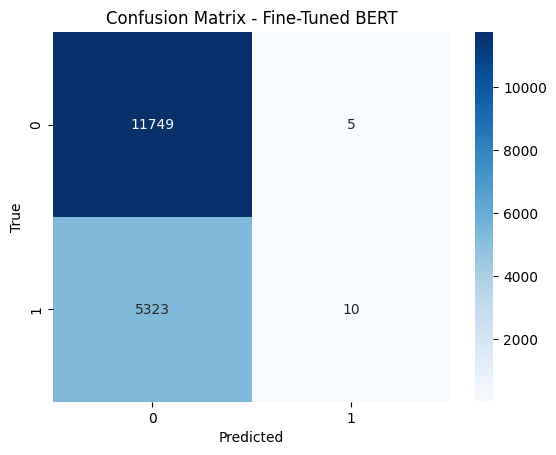

In [10]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare test set from the processed CSV
import pandas as pd
test_df = pd.read_csv("../data/processed_hc3.csv")
test_df = test_df.dropna(subset=['text'])
test_df = test_df[test_df['text'].str.strip() != ""]

# Use the last 20% as test set (matching train/val split in train_bert.py)
from sklearn.model_selection import train_test_split
_, X_test, _, y_test = train_test_split(
    test_df['text'], test_df['label'], test_size=0.2, random_state=42
)
test_texts = X_test.tolist()
test_labels = y_test.tolist()

# Get predictions from the fine-tuned model
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import torch

model_dir = '../models/bert_model'
tokenizer = DistilBertTokenizer.from_pretrained(model_dir)
model = DistilBertForSequenceClassification.from_pretrained(model_dir)
model.eval()

predictions = []
pred_probs = []

with torch.no_grad():
    for text in test_texts:
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=1)
        pred_label = torch.argmax(probs, dim=1).item()
        predictions.append(pred_label)
        pred_probs.append(probs[0,1].item())  # Probability of class 1 (AI-generated)

y_true = np.array(test_labels)
y_pred = np.array(predictions)
print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Fine-Tuned BERT")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

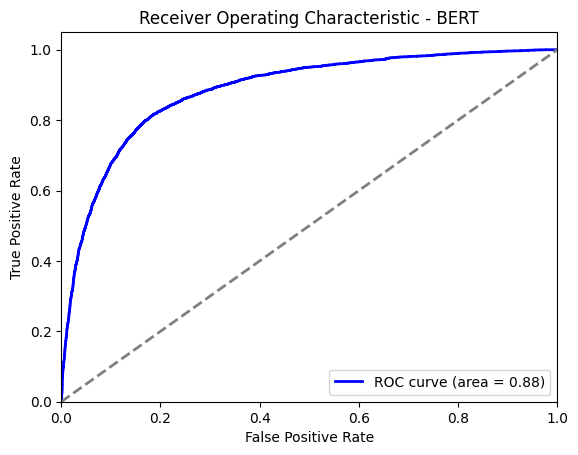

In [11]:
y_pred_prob = np.array(pred_probs)
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - BERT')
plt.legend(loc="lower right")
plt.show()

In [12]:
for i in range(5):
    print(f"Text: {test_texts[i][:200]}...")
    print(f"True Label: {y_true[i]}, Predicted: {y_pred[i]}, Probability: {y_pred_prob[i]:.4f}\n")

Text: TV & Movies tend to repeat patterns that work . One sitcom came up with a fat stupid guy married to an attractive , smarter wife . It was a success , and the rest copied it as much as they could , dow...
True Label: 0, Predicted: 0, Probability: 0.3055

Text: Well , first off , wifi has a short range -- a few hundred feet . That 's because it uses unlicensed spectrum at low power . Secondly , it 's not just the wifi -- it 's the Internet connectivity that ...
True Label: 0, Predicted: 0, Probability: 0.2893

Text: A million subscribers is n't cool You know what 's cool ? A billion subscribers...
True Label: 0, Predicted: 0, Probability: 0.2834

Text: It 's the same reason people will go to McDonald 's anywhere on the globe , when authentic local food is available . Consistency . When you order your drink at Starbucks you know EXACTLY how it is goi...
True Label: 0, Predicted: 0, Probability: 0.3066

Text: The moon can appear to be very large and bright in the sky because it is re